# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the [Human Value Detection challenge](https://aclanthology.org/2022.acl-long.306/).

## Problem definition

Arguments are paired with their conveyed human values.

Arguments are in the form of **premise** $\rightarrow$ **conclusion**.

### Example:

**Premise**: *``fast food should be banned because it is really bad for your health and is costly''*

**Conclusion**: *``We should ban fast food''*

**Stance**: *in favour of*

<center>
    <img src="images/human_values.png" alt="human values" />
</center>

# [Task 1 - 0.5 points] Corpus

Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

The challenge offers several corpora for evaluation and testing.

You are going to work with the standard training, validation, and test splits.

#### Arguments
* arguments-training.tsv
* arguments-validation.tsv
* arguments-test.tsv

#### Human values
* labels-training.tsv
* labels-validation.tsv
* labels-test.tsv

### Example

#### arguments-*.tsv
```

Argument ID    A01005

Conclusion     We should ban fast food

Stance         in favor of

Premise        fast food should be banned because it is really bad for your health and is costly.
```

#### labels-*.tsv

```
Argument ID                A01005

Self-direction: thought    0
Self-direction: action     0
...
Universalism: objectivity: 0
```

### Splits

The standard splits contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

### Instructions

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

### Libraries Import - Utils

In [137]:
import os
import urllib.request
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from datasets import *
import transformers
from transformers import AutoTokenizer, PreTrainedTokenizerFast, BertForSequenceClassification, DefaultDataCollator, Trainer, TrainingArguments
import plotly.express as px
import random
from sklearn.metrics import f1_score
from torch.optim import AdamW
from transformers.optimization import get_scheduler #, AdamW
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings("ignore")

# Setting seeds for reproducibility
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    transformers.set_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed = 42    
set_reproducibility(seed)

# If 'False', the notebook will perform a training session, otherwise it will load the 
# last model-checkpoint fine-tuned
load_model = False

In [165]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     

print("Using device:", device)

Using device: cpu


### Download the specificed training, validation, and test files.

In [64]:
# Arguments Download    
train_url = 'https://zenodo.org/records/8248658/files/arguments-training.tsv'
val_url = 'https://zenodo.org/records/8248658/files/arguments-validation.tsv'
test_url = 'https://zenodo.org/records/8248658/files/arguments-test.tsv'

urllib.request.urlretrieve(train_url, os.path.basename(train_url))
urllib.request.urlretrieve(val_url, os.path.basename(val_url))
urllib.request.urlretrieve(test_url, os.path.basename(test_url))

# Labels Download
ltrain_url = 'https://zenodo.org/records/8248658/files/labels-training.tsv'
lval_url = 'https://zenodo.org/records/8248658/files/labels-validation.tsv'
ltest_url = 'https://zenodo.org/records/8248658/files/labels-test.tsv'

urllib.request.urlretrieve(ltrain_url, os.path.basename(ltrain_url))
urllib.request.urlretrieve(lval_url, os.path.basename(lval_url))
urllib.request.urlretrieve(ltest_url, os.path.basename(ltest_url))

('labels-test.tsv', <http.client.HTTPMessage at 0x25dbc25e8f0>)

In [28]:
train_data = "arguments-training.tsv"
val_data = "arguments-validation.tsv"
test_data = "arguments-test.tsv"

train_labels = "labels-training.tsv"
val_labels = "labels-validation.tsv"
test_labels = "labels-test.tsv"

### Encode split files into a pandas.DataFrame object.

In [29]:
train_df = pd.read_csv(train_data, sep='\t')
val_df = pd.read_csv(val_data, sep='\t')
test_df = pd.read_csv(test_data, sep='\t')

print("Training Set Shape:", train_df.shape[0],"x", train_df.shape[1])
print("Validation Set Shape:", val_df.shape[0],"x", val_df.shape[1])
print("Test Set Shape:", test_df.shape[0],"x", test_df.shape[1],"\n")

ltrain_df = pd.read_csv(train_labels, sep='\t')
lval_df = pd.read_csv(val_labels, sep='\t')
ltest_df = pd.read_csv(test_labels, sep='\t')

print("Training Labels Shape:", ltrain_df.shape[0],"x", ltrain_df.shape[1])
print("Validation Labels Shape:", lval_df.shape[0],"x", lval_df.shape[1])
print("Test Labels Shape:", ltest_df.shape[0],"x", ltest_df.shape[1])

Training Set Shape: 5393 x 4
Validation Set Shape: 1896 x 4
Test Set Shape: 1576 x 4 

Training Labels Shape: 5393 x 21
Validation Labels Shape: 1896 x 21
Test Labels Shape: 1576 x 21


In [5]:
path_labels_data = ".\labels_data"
path_arguments_data = ".\\arguments_data"

def load_file():
    '''Load the file and return the data and labels for training, testing and validation'''
    
    train_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-training.tsv'), sep='\t')
    test_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-test.tsv'), sep='\t')
    valid_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-validation.tsv'), sep='\t')
    train_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-training.tsv'),sep='\t')
    test_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-test.tsv'),sep='\t')
    valid_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-validation.tsv'),sep='\t')

    return (train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels)
    



(train_df,ltrain_df), (test_df,ltest_df), (val_df,lval_df) = load_file()

print("Training Set Shape:", train_df.shape[0],"x", train_df.shape[1])
print("Validation Set Shape:", val_df.shape[0],"x", val_df.shape[1])
print("Test Set Shape:", test_df.shape[0],"x", test_df.shape[1],"\n")

print("Training Labels Shape:", ltrain_df.shape[0],"x", ltrain_df.shape[1])
print("Validation Labels Shape:", lval_df.shape[0],"x", lval_df.shape[1])
print("Test Labels Shape:", ltest_df.shape[0],"x", ltest_df.shape[1])

Training Set Shape: 5393 x 4
Validation Set Shape: 1896 x 4
Test Set Shape: 1576 x 4 

Training Labels Shape: 5393 x 21
Validation Labels Shape: 1896 x 21
Test Labels Shape: 1576 x 21


#### Data Inspection

In [30]:

print('Training Dataframe Head')
train_df.head()

Training Dataframe Head


,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [31]:
print("Summary Statistics:")
train_df.describe()

Summary Statistics:


,Argument ID,Conclusion,Stance,Premise
count,5393,5393,5393,5393
unique,5393,332,2,5313
top,A01002,We should abolish the three-strikes laws,in favor of,Migrants sell drugs.
freq,1,114,2898,2


In [32]:
print("Labels:", ltrain_df.columns.tolist())

Labels: ['Argument ID', 'Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']


In [33]:

print('Training Labels Dataframe Head')
ltrain_df.head()

Training Labels Dataframe Head


,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,A01006,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01007,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


### For each split, merge the arguments and labels dataframes into a single dataframe.

In [6]:
def merge_df(data, labels):
    return pd.merge(data, labels, on='Argument ID')

In [143]:
train_df_merged = merge_df(train_df, ltrain_df)
val_df_merged = merge_df(val_df, lval_df)
test_df_merged = merge_df(test_df, ltest_df)
print("Training Merged Set Shape:", train_df_merged.shape[0],"x", train_df_merged.shape[1])
print("Validation Merged Set Shape:", val_df_merged.shape[0],"x", val_df_merged.shape[1])
print("Test Merged Set Shape:", test_df_merged.shape[0],"x", test_df_merged.shape[1], '\n')

print('Merged Training Dataframe Head')
train_df_merged.head()

Training Merged Set Shape: 5393 x 24
Validation Merged Set Shape: 1896 x 24
Test Merged Set Shape: 1576 x 24 

Merged Training Dataframe Head


,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [9]:
datasets = {"Training":train_df_merged, "Validation":val_df_merged, "Test":test_df_merged}
for i,key in enumerate(datasets.keys()):
    print(f"Number of null values in {key} set: ", datasets[key].isnull().sum().sum())

Number of null values in Training set:  0
Number of null values in Validation set:  0
Number of null values in Test set:  0


In [40]:
for column in train_df_merged.iloc[:,4:].columns:
    print(f"\nUnique values taken by \"{column}\" label: {np.unique(train_df_merged[column].values)}")
    



Unique values taken by "Self-direction: thought" label: [0 1]

Unique values taken by "Self-direction: action" label: [0 1]

Unique values taken by "Stimulation" label: [0 1]

Unique values taken by "Hedonism" label: [0 1]

Unique values taken by "Achievement" label: [0 1]

Unique values taken by "Power: dominance" label: [0 1]

Unique values taken by "Power: resources" label: [0 1]

Unique values taken by "Face" label: [0 1]

Unique values taken by "Security: personal" label: [0 1]

Unique values taken by "Security: societal" label: [0 1]

Unique values taken by "Tradition" label: [0 1]

Unique values taken by "Conformity: rules" label: [0 1]

Unique values taken by "Conformity: interpersonal" label: [0 1]

Unique values taken by "Humility" label: [0 1]

Unique values taken by "Benevolence: caring" label: [0 1]

Unique values taken by "Benevolence: dependability" label: [0 1]

Unique values taken by "Universalism: concern" label: [0 1]

Unique values taken by "Universalism: nature" l

In [42]:
counts_train = train_df_merged.iloc[:,4:].eq(1).sum()
total_counts_train = counts_train.sum()
print("Count of Level 2 categories in Training Dataset: \n\n{}".format(counts_train))
print("\nTotal count of Level 2 categories in Training Dataset: {}".format(total_counts_train))

Count of Level 2 categories in Training Dataset: 

Self-direction: thought        988
Self-direction: action        1395
Stimulation                    247
Hedonism                       172
Achievement                   1512
Power: dominance               610
Power: resources               625
Face                           382
Security: personal            2000
Security: societal            1728
Tradition                      568
Conformity: rules             1177
Conformity: interpersonal      207
Humility                       395
Benevolence: caring           1332
Benevolence: dependability     806
Universalism: concern         2081
Universalism: nature           427
Universalism: tolerance        664
Universalism: objectivity     1054
dtype: int64

Total count of Level 2 categories in Training Dataset: 18370


In [45]:
#Important dictionary to map the labels to the correct index
level2_to_level3 = {
    'openness_to_change':["Self-direction: thought", "Self-direction: action","Stimulation", "Hedonism"],
    'self_enhancement':['Hedonism','Achievement', 'Power: dominance', 'Power: resources','Face'],
    'conservation': ['Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal','Humility'],
    'self_transcendence':['Humility', 'Benevolence: caring', 'Benevolence: dependability','Universalism: concern', 'Universalism: nature','Universalism: tolerance', 'Universalism: objectivity']
}

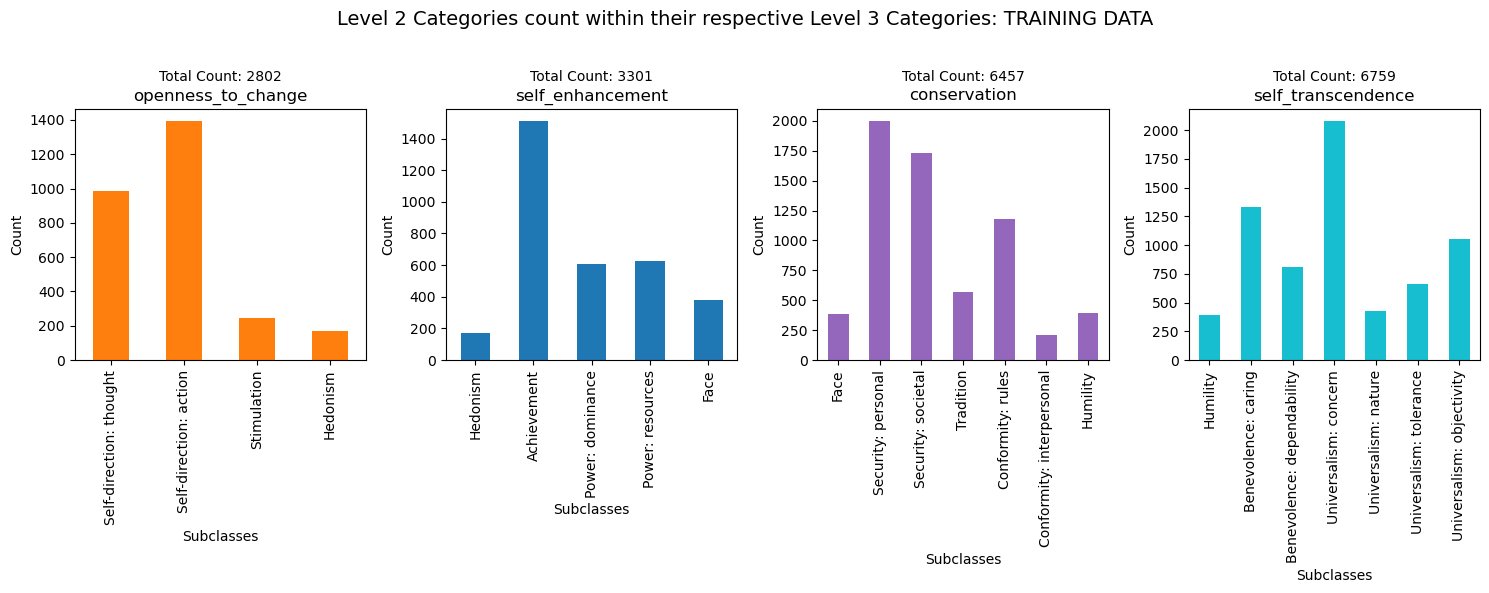

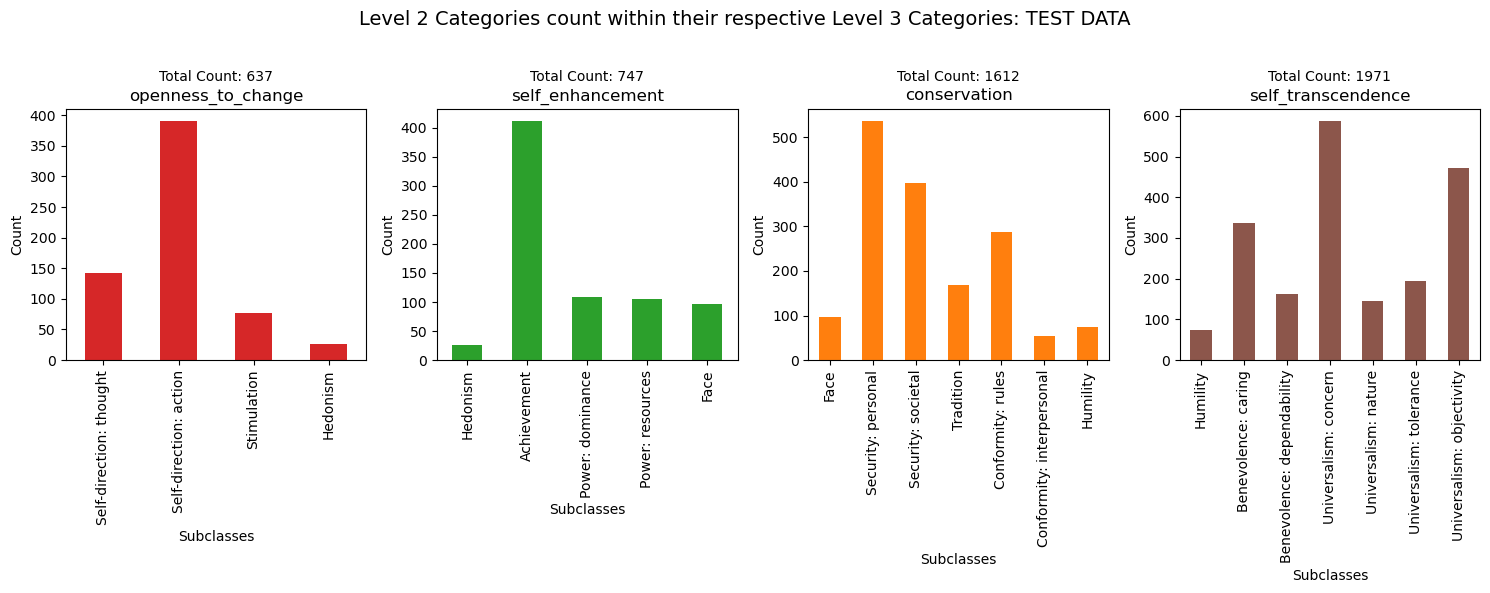

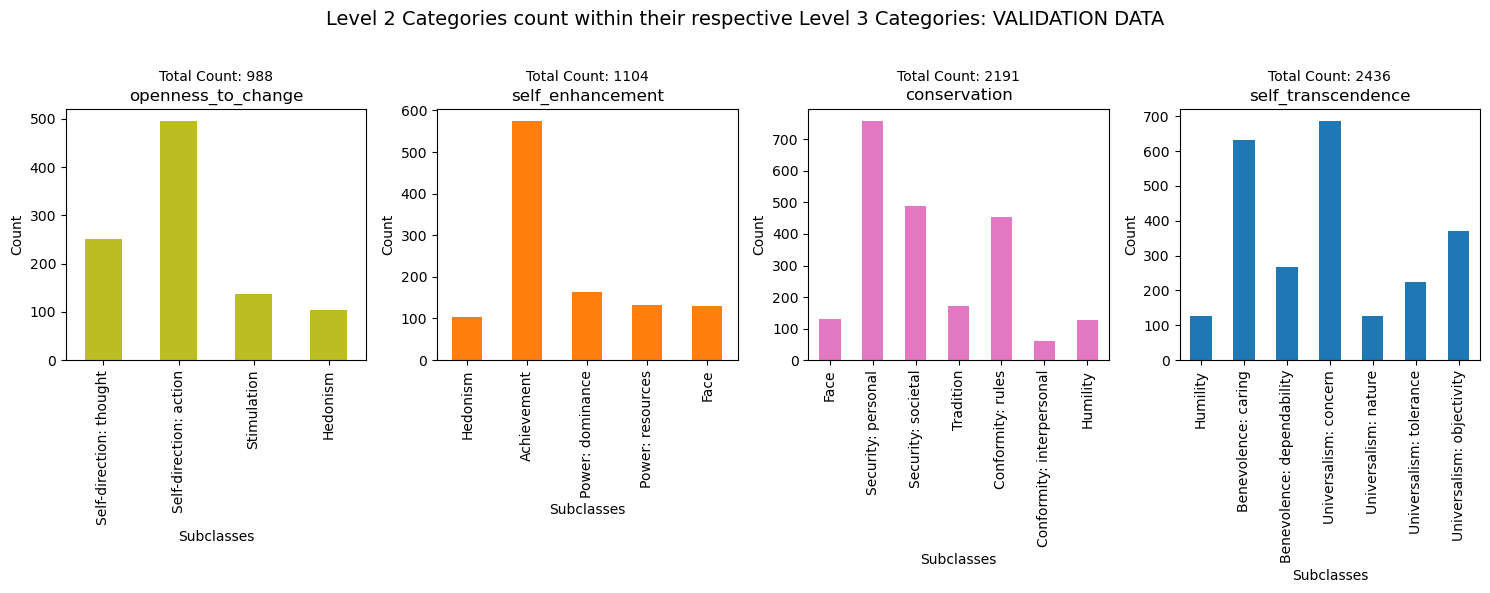

In [47]:
def plot_l2_to_l3_count(df:pd.DataFrame, title):
    '''Plot the histogram of the labels'''
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,6 ))
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    
    for i, (label, subclasses) in enumerate(level2_to_level3.items()):
        ax = axes[i]
        df[subclasses].eq(1).sum().plot(kind='bar', ax=ax, color=colors[i])
        ax.set_title(f'{label}')
        ax.set_xlabel('Subclasses')
        ax.set_ylabel('Count')
        total_count = df[subclasses].eq(1).sum().sum() 
        ax.text(0.5, 1.11, f'Total Count: {total_count}', transform=ax.transAxes, ha='center')  
        
    plt.suptitle(f"Level 2 Categories count within their respective Level 3 Categories: {str.upper(title)} DATA",fontsize=14)
    plt.tight_layout()
    plt.show()

plot_l2_to_l3_count(train_df_merged, "Training")
plot_l2_to_l3_count(test_df_merged, "Test")
plot_l2_to_l3_count(val_df_merged, "Validation")

    

### Merge level 2 annotations to level 3 categories.

In [48]:
def lv3_labels(df):
    """
    Function to aggregate specified columns by taking the logical OR between their values.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: A new DataFrame with aggregated values.
    """
    
    # Create a new DataFrame to store aggregated values
    new_df = pd.DataFrame()
    
    # Iterate over the mapping and compute logical OR for each set of columns
    for new_column, columns_to_aggregate in level2_to_level3.items():
        new_df[new_column] = df[columns_to_aggregate].apply(lambda row: any(row), axis=1).astype(int)  # Convert boolean to int
    
    # Drop the original columns used for aggregation
    df.drop(columns=[col for cols in level2_to_level3.values() for col in cols], inplace=True)
    
    # Concatenate new DataFrame with the remaining columns of the original DataFrame
    new_df = pd.concat([df, new_df], axis=1)
    
    return new_df


In [144]:
df_train = lv3_labels(train_df_merged)
df_val = lv3_labels(val_df_merged)
df_test = lv3_labels(test_df_merged)

print("Final Training Set Shape:", df_train.shape[0],"x", df_train.shape[1])
print("Final Validation Set Shape:", df_val.shape[0],"x", df_val.shape[1])
print("Final Set Shape:", df_test.shape[0],"x", df_test.shape[1], '\n')

df_train.head()

Final Training Set Shape: 5393 x 8
Final Validation Set Shape: 1896 x 8
Final Set Shape: 1576 x 8 



,Argument ID,Conclusion,Stance,Premise,openness_to_change,self_enhancement,conservation,self_transcendence
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,1,1


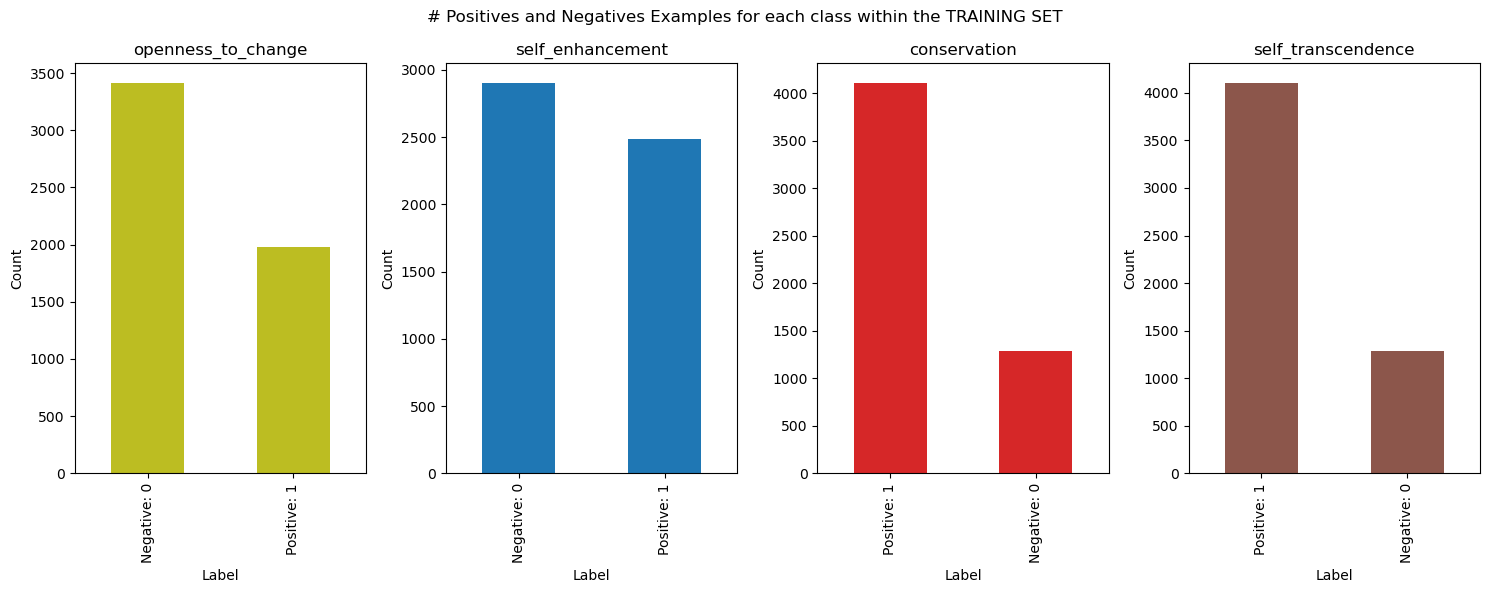

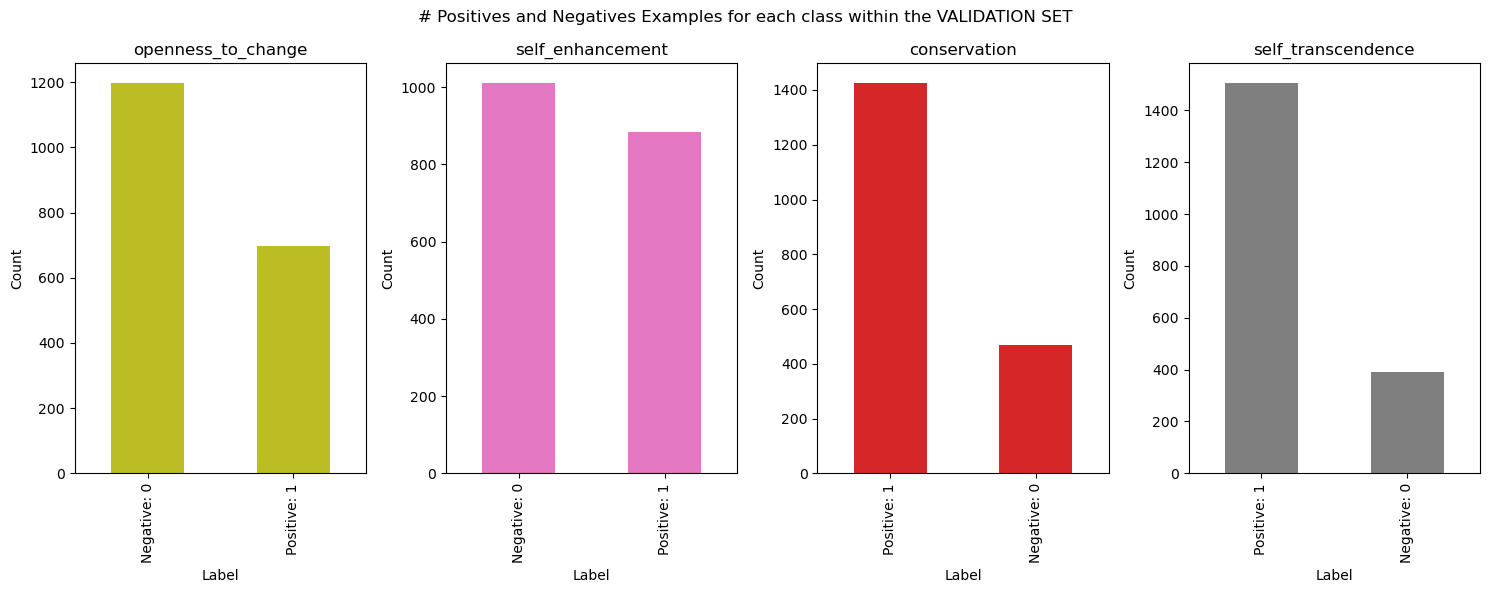

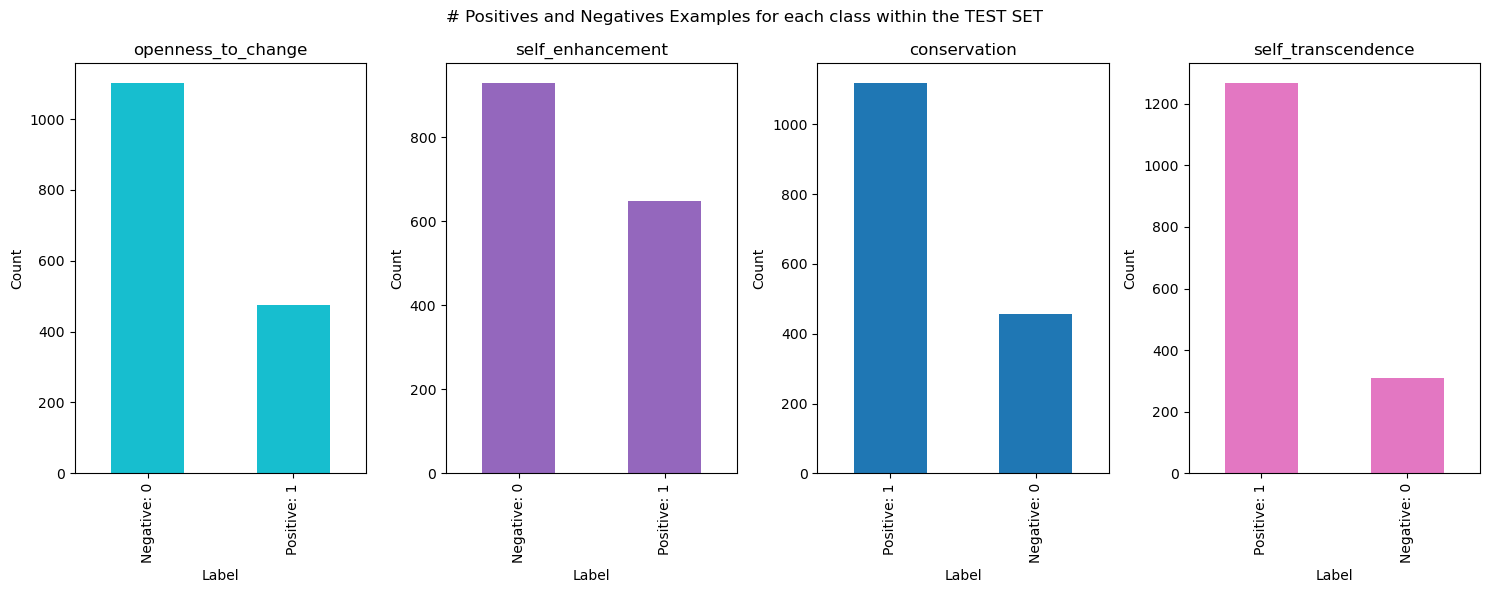

In [51]:
def plot_label_count(df: pd.DataFrame, title:str):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    labels = list(level2_to_level3.keys())


    for i,label in enumerate(labels):
        ax = axes[i]
        count_labels = df[label].replace({0: 'Negative: 0', 1: 'Positive: 1'}).value_counts()
        count_labels.plot(kind='bar', ax=ax, color=colors[i], label=label)
        ax.set_title(f'{label}')
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        
    plt.suptitle(f'# Positives and Negatives Examples for each class within the {str.upper(title)} SET', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_label_count(df_train,"training")
plot_label_count(df_val,"Validation")
plot_label_count(df_test,"Test")

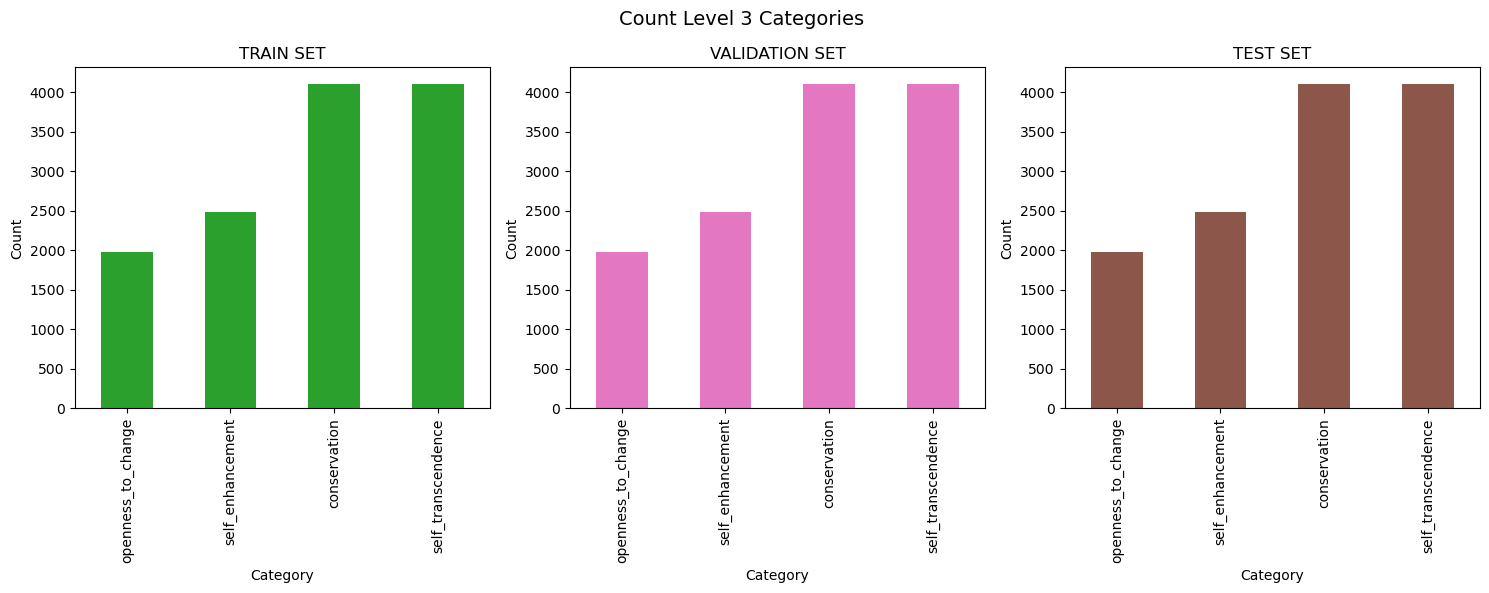

In [53]:
def plot_samples_per_class(df_train, df_valid, df_test):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    axes = axes.flatten()
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    labels = list(level2_to_level3.keys())

    for i in range(3):
        ax = axes[i]
        train_counts = df_train[labels].eq(1).sum()
        valid_counts = df_valid[labels].eq(1).sum()
        test_counts = df_test[labels].eq(1).sum()
        
        train_counts.plot(kind='bar', ax=ax, color=colors[i])
        valid_counts.plot(kind='bar', ax=ax, color=colors[i])
        test_counts.plot(kind='bar', ax=ax, color=colors[i])
        ax.set_title(f'{["TRAIN SET", "VALIDATION SET", "TEST SET"][i]}')
        ax.set_xlabel('Category')
        ax.set_ylabel('Count')
        ax.set_xticklabels(labels)

        
    plt.suptitle('Count Level 3 Categories ', fontsize=14)
    plt.tight_layout()
    plt.show()


plot_samples_per_class(df_train,df_val,df_test)

In [131]:
df_train.describe()

,openness_to_change,self_enhancement,conservation,self_transcendence
count,5393.000000,5393.000000,5393.000000,5393.000000
mean,0.366957,0.461524,0.761543,0.761172
std,0.482019,0.498564,0.426180,0.426407
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [100]:
def compute_labels_prob_distribution(df,title):
    prob_distr = {}
    for column in df.columns[4:]:
        most_frequent_value = df[column].value_counts(normalize = True).idxmax()
        less_frequent_value = df[column].value_counts(normalize = True).idxmin()
        frequency = df[column].value_counts(normalize = True).round(2).iloc[0]
        prob_distr[column] = [frequency, most_frequent_value]
    
    return prob_distr
        
        
compute_labels_prob_distribution(df_train,"train")


{'openness_to_change': [0.63, 0],
 'self_enhancement': [0.54, 0],
 'conservation': [0.76, 1],
 'self_transcendence': [0.76, 1]}

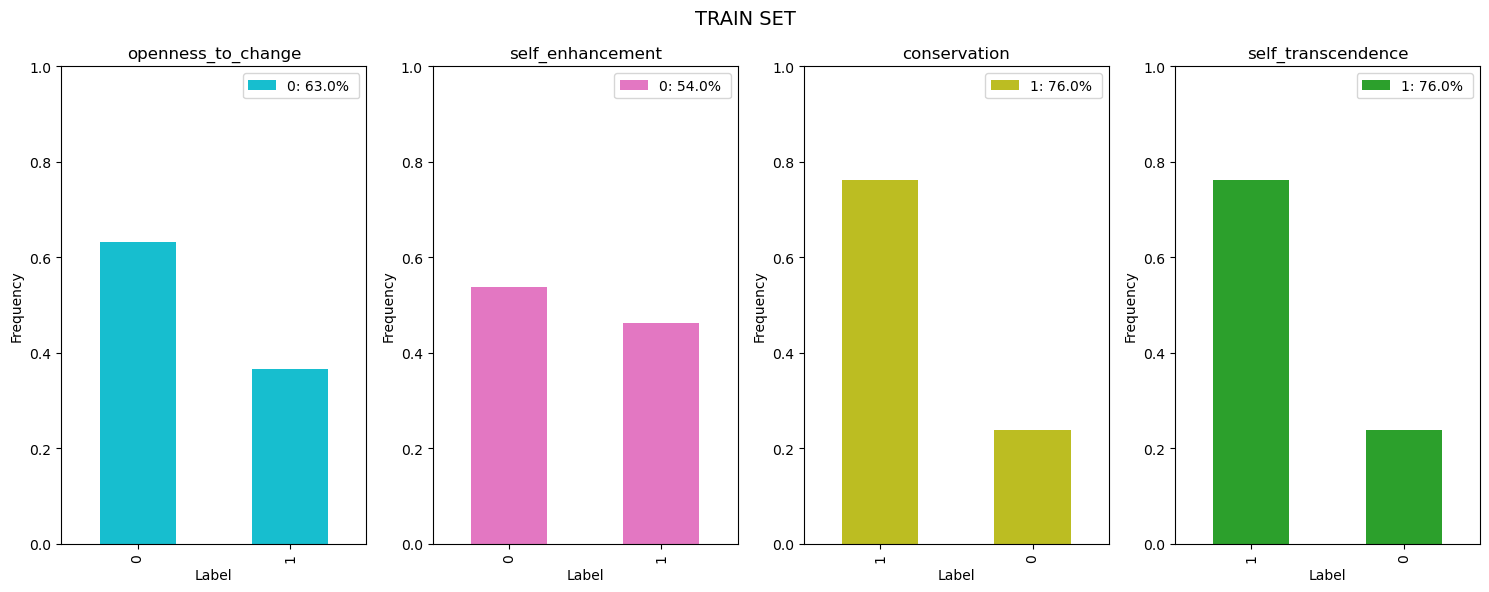

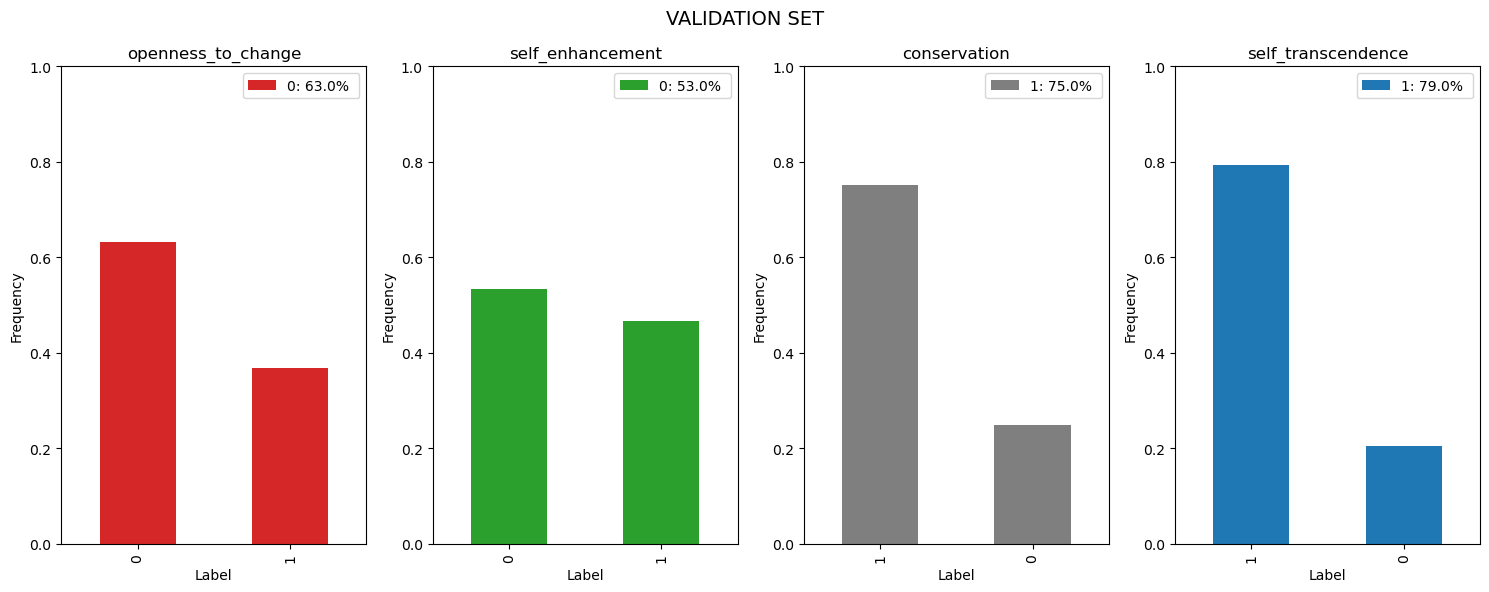

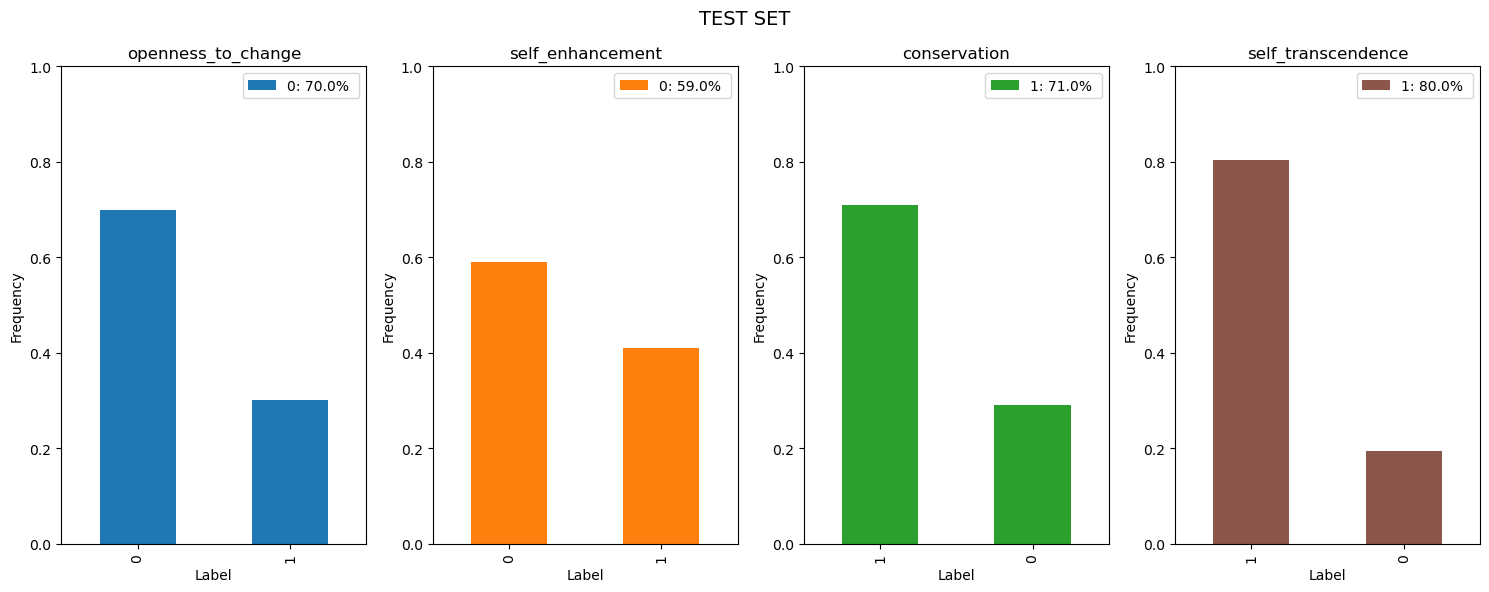

In [108]:
def plot_probability_distribution(dataframe, title):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    prob_distr = compute_labels_prob_distribution(dataframe, title)      
    for i,column in enumerate(dataframe.columns[4:]):
        ax = axes[i]
        dataframe[column].value_counts(normalize=True).plot(kind='bar', ax=ax, color=colors[i])
        ax.set_title(f'{dataframe[column].name}')
        ax.set_xlabel('Label')
        ax.set_ylabel('Frequency')
        ax.set_ylim(0, 1)
        
        most_freq = f"{prob_distr[column][1]}: {prob_distr[column][0]*100}% "
        less_freq = f"{(1 - prob_distr[column][0]*100).round(2)}%"
        ax.legend([most_freq,less_freq], loc='upper right', ncol=1)
    
    plt.suptitle(f'{str.upper(title)} SET', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_probability_distribution(df_train, "train")
plot_probability_distribution(df_val, "validation")
plot_probability_distribution(df_test, "test")


### Datasets preparation

#### Exploring sentences

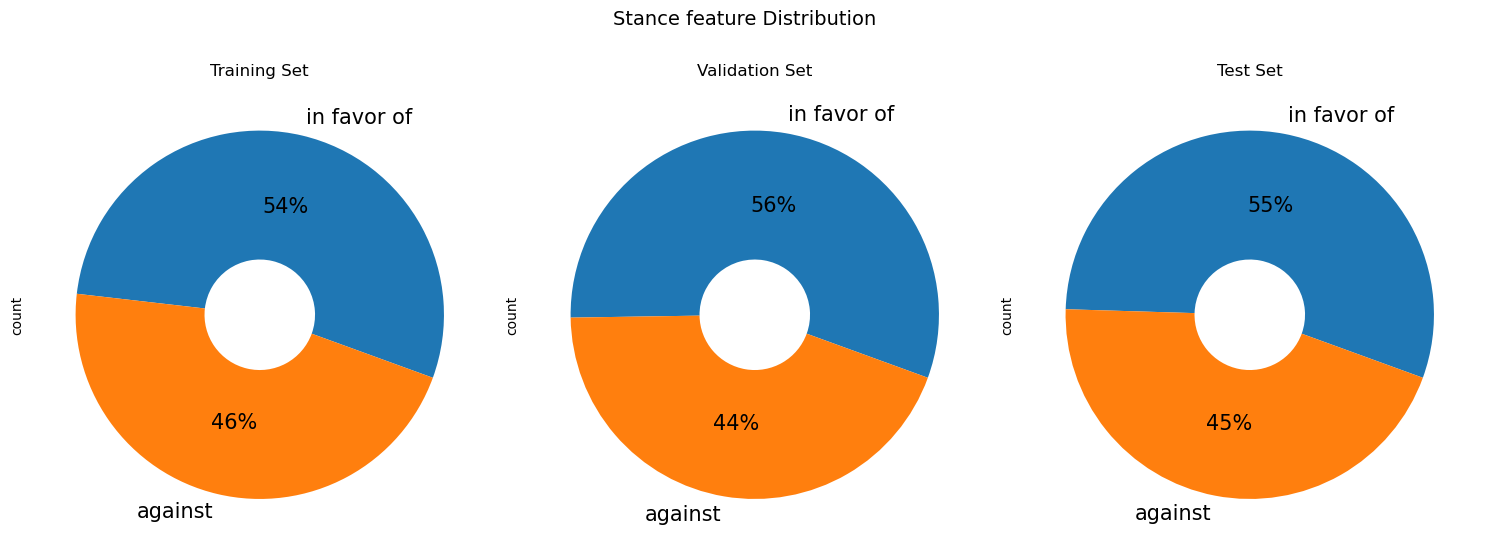

In [109]:
def plot_stance_distribution(train_df,valid_df,test_df):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    
    train_df["Stance"].value_counts().plot(kind='pie', labels=['in favor of', 'against'],
                                    wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                                    textprops={'fontsize': 15}, ax=ax[0])
    ax[0].set_title('Training Set')
    valid_df["Stance"].value_counts().plot(kind='pie', labels=['in favor of', 'against'],
                                    wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                                    textprops={'fontsize': 15}, ax=ax[1])
    ax[1].set_title('Validation Set')
    test_df["Stance"].value_counts().plot(kind='pie', labels=['in favor of', 'against'],
                                    wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                                    textprops={'fontsize': 15}, ax=ax[2])
    ax[2].set_title('Test Set')
    

    plt.suptitle('Stance feature Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_stance_distribution(df_train,df_val,df_test)

In [149]:
def refine_df(df):
    new_df = df.copy()
    new_df["Stance"] = df['Stance'].replace({'in favor of': 1, 'against': 0})
    new_df.drop(df.columns[4:], axis=1, inplace=True)
    new_df['labels'] = df.iloc[:, 4:].apply(lambda x: np.array(list(x)), axis=1)
    return new_df

df_train = refine_df(df_train)
df_test = refine_df(df_test)
df_val = refine_df(df_val)

df_train.head()

,Argument ID,Conclusion,Stance,Premise,labels
0,A01002,We should ban human cloning,1,we should ban human cloning as it will only ca...,"[0, 0, 1, 0]"
1,A01005,We should ban fast food,1,fast food should be banned because it is reall...,"[0, 0, 1, 0]"
2,A01006,We should end the use of economic sanctions,0,sometimes economic sanctions are the only thin...,"[0, 1, 1, 0]"
3,A01007,We should abolish capital punishment,0,capital punishment is sometimes the only optio...,"[0, 0, 1, 1]"
4,A01008,We should ban factory farming,0,factory farming allows for the production of c...,"[0, 0, 1, 1]"


In [150]:
# Relevant features for the dataset
featurez = ['Conclusion', 'Premise', 'Stance', 'labels']

# Dataframes to Datasets
train_df_to_ds = df_train[featurez]
val_df_to_ds = df_val[featurez]
test_df_to_ds = df_test[featurez]

train_df_to_ds = train_df_to_ds.rename(columns={'Conclusion': 'conclusion', 'Premise': 'premise', 'Stance': 'stance'})
val_df_to_ds = val_df_to_ds.rename(columns={'Conclusion': 'conclusion', 'Premise': 'premise', 'Stance': 'stance'})
test_df_to_ds = test_df_to_ds.rename(columns={'Conclusion': 'conclusion', 'Premise': 'premise', 'Stance': 'stance'})

train_df_to_ds.head()

,conclusion,premise,stance,labels
0,We should ban human cloning,we should ban human cloning as it will only ca...,1,"[0, 0, 1, 0]"
1,We should ban fast food,fast food should be banned because it is reall...,1,"[0, 0, 1, 0]"
2,We should end the use of economic sanctions,sometimes economic sanctions are the only thin...,0,"[0, 1, 1, 0]"
3,We should abolish capital punishment,capital punishment is sometimes the only optio...,0,"[0, 0, 1, 1]"
4,We should ban factory farming,factory farming allows for the production of c...,0,"[0, 0, 1, 1]"


In [151]:
def string_lengths_stats(dataframe, column_name1, column_name2):
    # Extract the columns
    column_data1 = dataframe[column_name1]
    column_data2 = dataframe[column_name2]
    
    # Calculate lengths of strings for column 1
    lengths1 = column_data1.astype(str).apply(len)
    # Calculate statistics for column 1
    max_length1 = lengths1.max()
    mean_length1 = lengths1.mean()
    min_length1 = lengths1.min()
    
    # Calculate lengths of strings for column 2
    lengths2 = column_data2.astype(str).apply(len)
    # Calculate statistics for column 2
    max_length2 = lengths2.max()
    mean_length2 = lengths2.mean()
    min_length2 = lengths2.min()
    
    # Print values to the screen
    print("Statistics for", column_name1, ':')
    print("Maximum Length:", max_length1)
    print("Mean Length:", mean_length1)
    print("Minimum Length:", min_length1)
    
    print("\nStatistics for", column_name2, ':')
    print("Maximum Length:", max_length2)
    print("Mean Length:", mean_length2)
    print("Minimum Length:", min_length2,'\n')
        
print('---Training Set---\n')
string_lengths_stats(df_train, 'Premise', 'Conclusion')
print('---Validation Set---\n')
string_lengths_stats(df_val, 'Premise', 'Conclusion')
print('---Test Set---\n')
string_lengths_stats(df_test, 'Premise', 'Conclusion')


---Training Set---

Statistics for Premise :
Maximum Length: 792
Mean Length: 128.84980530317077
Minimum Length: 20

Statistics for Conclusion :
Maximum Length: 190
Mean Length: 39.70554422399407
Minimum Length: 21 

---Validation Set---

Statistics for Premise :
Maximum Length: 825
Mean Length: 130.90189873417722
Minimum Length: 35

Statistics for Conclusion :
Maximum Length: 184
Mean Length: 41.052742616033754
Minimum Length: 23 

---Test Set---

Statistics for Premise :
Maximum Length: 822
Mean Length: 128.79060913705584
Minimum Length: 35

Statistics for Conclusion :
Maximum Length: 157
Mean Length: 36.05774111675127
Minimum Length: 18 



In [152]:
# Check tokenizer special tokens
def check_tokens(tokenizer):
    # Get the special tokens and their corresponding IDs
    special_tokens = tokenizer.special_tokens_map
    special_ids = tokenizer.convert_tokens_to_ids(list(special_tokens.values()))
    print("Special tokens:")
    for token_type, token_list in special_tokens.items():
        print(f"{token_type}: {token_list}")
    # Print the special tokens and their corresponding IDs
    for token, id in zip(special_tokens.keys(), special_ids):
        print(f"{token}: {id}")

model_checkpoint = 'prajjwal1/bert-tiny' 
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
assert isinstance(tokenizer, PreTrainedTokenizerFast)

# Setting the BOS and EOS token
#tokenizer_M1.bos_token = tokenizer_M1.cls_token
#tokenizer_M1.eos_token = tokenizer_M1.sep_token
check_tokens(tokenizer)

Special tokens:
unk_token: [UNK]
sep_token: [SEP]
pad_token: [PAD]
cls_token: [CLS]
mask_token: [MASK]
unk_token: 100
sep_token: 102
pad_token: 0
cls_token: 101
mask_token: 103


In [153]:
tclengths = [len(tokenizer(x)["input_ids"]) for x in train_df_to_ds['conclusion']]
fig_inputs = px.box(list(tclengths),
                   title="Tokenized Conclusions Lengths Distribution - Training Set")
fig_inputs.show()

In [154]:
tplengths = [len(tokenizer(x)["input_ids"]) for x in train_df_to_ds['premise']]
fig_inputs = px.box(list(tplengths),
                   title="Tokenized Premises Lengths Distribution - Training Set")
fig_inputs.show()

In [155]:
vclengths = [len(tokenizer(x)["input_ids"]) for x in val_df_to_ds['conclusion']]
fig_inputs = px.box(list(vclengths),
                   title="Tokenized Conclusions Lengths Distribution - Validation Set")
fig_inputs.show()

In [156]:
vplengths = [len(tokenizer(x)["input_ids"]) for x in val_df_to_ds['premise']]
fig_inputs = px.box(list(vplengths),
                   title="Tokenized Premises Lengths Distribution - Validation Set")
fig_inputs.show()

In [157]:
wc_max_len = max(tclengths+vclengths)
wcp_max_len = wc_max_len + max(tplengths+tplengths) + 1
wcps_max_len = wcp_max_len + 2


print("wc_max_len:", wc_max_len)
print("wcp_max_len:", wcp_max_len)
print("wcps_max_len:", wcps_max_len)

wc_max_len: 38
wcp_max_len: 198
wcps_max_len: 200


In [158]:
def prepare_dataset_from_dataframe(df, tokenizer, max_len, model_ver='c'):
    
    if model_ver == 'c':
    # Tokenize conclusions
        encoded_conclusion = tokenizer(
            df['conclusion'].tolist(),
            max_length=max_len,
            truncation=False,
            padding='max_length',
            return_tensors='pt'
        )


        labels_tensor = torch.tensor(df['labels'].tolist(), dtype=torch.float)

    # Combine the encoded tensors into a Dataset
        encoded_dataset = Dataset.from_dict({
            'input_ids': encoded_conclusion['input_ids'],
            'attention_mask': encoded_conclusion['attention_mask'],
            'labels': labels_tensor
        })

    return encoded_dataset
'''
    # Convert stance and labels to PyTorch tensors
    stance_tensor = torch.tensor(df['stance'].tolist(), dtype=torch.float)
    # Tokenize premises
    encoded_premise = tokenizer(
        df['premise'].tolist(),
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    
    encoded_dataset = Dataset.from_dict({
            'input_ids_premise': encoded_premise['input_ids'],
            'attention_mask_premise': encoded_premise['attention_mask'],
            'input_ids_conclusion': encoded_conclusion['input_ids'],
            'attention_mask_conclusion': encoded_conclusion['attention_mask'],
            'stance': stance_tensor,
            'labels': labels_tensor
        })
'''

"\n    # Convert stance and labels to PyTorch tensors\n    stance_tensor = torch.tensor(df['stance'].tolist(), dtype=torch.float)\n    # Tokenize premises\n    encoded_premise = tokenizer(\n        df['premise'].tolist(),\n        max_length=max_len,\n        truncation=True,\n        padding='max_length',\n        return_tensors='pt'\n    )\n    \n    encoded_dataset = Dataset.from_dict({\n            'input_ids_premise': encoded_premise['input_ids'],\n            'attention_mask_premise': encoded_premise['attention_mask'],\n            'input_ids_conclusion': encoded_conclusion['input_ids'],\n            'attention_mask_conclusion': encoded_conclusion['attention_mask'],\n            'stance': stance_tensor,\n            'labels': labels_tensor\n        })\n"

# [Task 2 - 2.0 points] Model definition

You are tasked to define several neural models for multi-label classification.

<center>
    <img src="images/model_schema.png" alt="model_schema" />
</center>

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

### Notes

**Do not mix models**. Each model has its own instructions.

You are **free** to select the BERT-based model card from huggingface.

#### Examples

```
bert-base-uncased
prajjwal1/bert-tiny
distilbert-base-uncased
roberta-base
```

### BERT w/ C

<center>
    <img src="images/bert_c.png" alt="BERT w/ C" />
</center>

In [159]:

wc_datasets = DatasetDict()
# Map tokenization function to your dataset
wc_datasets['train'] = prepare_dataset_from_dataframe(train_df_to_ds, tokenizer, wc_max_len,'c')
wc_datasets['validation'] = prepare_dataset_from_dataframe(val_df_to_ds, tokenizer, wc_max_len,'c')
wc_datasets['test'] = prepare_dataset_from_dataframe(test_df_to_ds, tokenizer, wc_max_len,'c')
# Display the encoded dataset
print(wc_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5393
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1896
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1576
    })
})


In [166]:
num_labels = 4
# Load Model
if load_model:
    # Get list of all model checkpoints in the directory
    models_cps = filter( lambda x: len(x.split('_')) == 5 and x.split('_')[1] == 'M2' and x.split('_')[2] == str(seed),
                            os.listdir('.') )

    # Sort list of files based on last creation time in descending order
    model_checkpoint = sorted(models_cps, key = lambda x: os.path.getctime(os.path.join('.', x)), reverse = True)[0]
    model = BertForSequenceClassification.from_pretrained(model_checkpoint+'/model',num_labels=num_labels, problem_type="multi_label_classification")
else:
    model_checkpoint = 'prajjwal1/bert-tiny'
    model = BertForSequenceClassification.from_pretrained(model_checkpoint,num_labels=num_labels, problem_type="multi_label_classification")
    
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

### BERT w/ CP

<center>
    <img src="images/bert_cp.png" alt="BERT w/ CP" />
</center>

### BERT w/ CPS

<center>
    <img src="images/bert_cps.png" alt="BERT w/ CPS" />
</center>

### Input concatenation

<center>
    <img src="images/input_merging.png" alt="Input merging" />
</center>

### Notes

The **stance** input has to be encoded into a numerical format.

You **should** use the same model instance to encode **premise** and **conclusion** inputs.

# [Task 3 - 0.5 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Example

You start with individual predictions ($\rightarrow$ samples).

```
Openess to change:    0 0 1 0 1 1 0 ...
Self-enhancement:     1 0 0 0 1 0 1 ...
Conversation:         0 0 0 1 1 0 1 ...
Self-transcendence:   1 1 0 1 0 1 0 ...
```

You compute per-category binary F1-score.

```
Openess to change F1:    0.35
Self-enhancement F1:     0.55
Conversation F1:         0.80
Self-transcendence F1:   0.21
```

You then average per-category scores.
```
Average F1: ~0.48
```

In [161]:
def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions.predictions, eval_predictions.label_ids
    macro_f1_score = compute_f1_macro(labels, predictions)
    return {"macro_f1": macro_f1_score}
'''
def compute_f1_macro(labels, predictions, threshold=0.5):
    binary_predictions = (predictions > threshold).astype(int)
    f1_macro = f1_score(y_true=labels, y_pred=binary_predictions, average='macro')
    return f1_macro
'''
from sklearn.metrics import f1_score, precision_recall_fscore_support

def compute_f1_macro(labels, predictions, threshold=0.5, print_per_category=False):
    binary_predictions = (predictions > threshold).astype(int)
    f1_macro = f1_score(y_true=labels, y_pred=binary_predictions, average='macro')
    if print_per_category:
        per_category_scores = precision_recall_fscore_support(labels, binary_predictions, average=None)
        print("Per-category F1 scores:")
        for i, score in enumerate(per_category_scores[2]):
            print(f"Category {i+1}: {score}")
    return f1_macro

# [Task 4 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

In [162]:
# Class Weights
def compute_class_weights_from_df(df):
    # Extracting labels
    labels = df['labels'].tolist()
    
    # Convert labels to 2D array
    labels_array = np.array([np.array(label) for label in labels])
    
    # Compute class frequencies
    class_frequencies = np.sum(labels_array, axis=0) / len(labels_array)
    
    # Compute inverse class frequencies
    inverse_class_frequencies = 1 / class_frequencies
    
    print("Inverse Class Frequencies:", inverse_class_frequencies)
    
    return inverse_class_frequencies



In [163]:
# weighted loss implementation
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Get the outputs from the model
        outputs = model(**inputs)

        # Custom logic to compute the loss
        loss = weighted_loss(outputs.logits, inputs['labels'], self.class_weights)

        return (loss, outputs) if return_outputs else loss

def weighted_loss(logits, labels, class_weights):
    # Ensure labels are on the same device as logits
    labels = labels.to(device)

    # Compute binary cross-entropy loss with class weights
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels, weight=class_weights.to(device))
    return loss

In [171]:
# Initialize the data collator
data_collator = DefaultDataCollator()

# Training hyperparameters
epochs = 10
batch_size = 64
learning_rate = 1e-3

# Calculate class weights for dealing with class imbalance
class_weights = compute_class_weights_from_df(train_df_to_ds)

# Training arguments
training_args = TrainingArguments(
    output_dir='./Model_Checkpoints',
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True if device == 'cuda' else False,
    num_train_epochs=epochs,
    logging_steps=100,
    logging_dir='./logs',
    learning_rate=learning_rate,
    save_strategy='epoch',
    metric_for_best_model='macro_f1',
    load_best_model_at_end=True,
    save_total_limit=1,
)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(wc_datasets['train']) // batch_size * epochs,
)

# Trainer definition
trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=wc_datasets['train'],
    eval_dataset=wc_datasets['validation'],
    optimizers=(optimizer, scheduler),
    class_weights=class_weights,
)

if not load_model:
    # Start the training
    trainer.train()


Inverse Class Frequencies: [2.72511369 2.16673363 1.31312393 1.3137637 ]


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [69]:
# Evaluation on the Test set
predictions = trainer.predict(wc_datasets['test'])
predicted_labels = predictions.predictions
true_labels = wc_datasets['test']['labels']


compute_f1_macro(true_labels, predicted_labels, threshold=0.5, print_per_category=True)

Per-category F1 scores:
Category 1: 0.035856573705179286
Category 2: 0.3445287107258938
Category 3: 0.7870813397129186
Category 4: 0.8787446504992866


0.5115528186608196

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

# [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

### Notes

You can check the [original paper](https://aclanthology.org/2022.acl-long.306/) for suggestions on how to perform comparisons (e.g., plots, tables, etc...).

# [Task 6 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Model card

You are **free** to choose the BERT-base model card you like from huggingface.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Model Training

You are **free** to choose training hyper-parameters for BERT-based models (e.g., number of epochs, etc...).

### Neural Libraries

You are **free** to use any library of your choice to address the assignment (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

# The End